count    29.000000
mean      2.130345
std       0.289772
min       1.550000
25%       1.850000
50%       2.130000
75%       2.390000
max       2.410000
Name: FF, dtype: float64
Actual=1.900000, Predicted=2.180137
Actual=1.850000, Predicted=1.936070
Actual=1.820000, Predicted=1.825687
Actual=1.840000, Predicted=1.793901
Actual=1.850000, Predicted=1.812093


/Users/sadikerisen/opt/anaconda3/envs/forecastingInterestRate/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)
/Users/sadikerisen/opt/anaconda3/envs/forecastingInterestRate/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-WED will be used.
  % freq, ValueWarning)


Actual=1.830000, Predicted=1.824806
Actual=1.570000, Predicted=1.807003
Actual=1.550000, Predicted=1.554426
Actual=1.550000, Predicted=1.517722
Test Mean Squared Error (smaller the better fit): 0.016


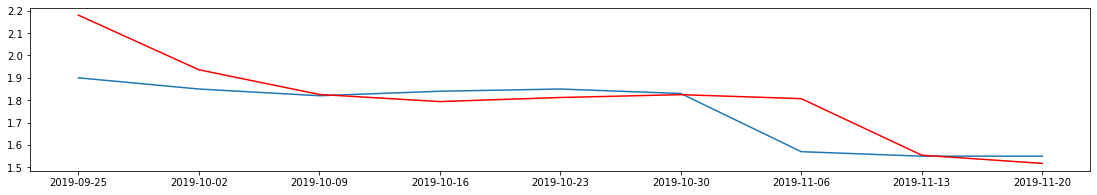

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from abc import ABC, abstractclassmethod, abstractmethod
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


pd.set_option("display.max_rows",4999)

class FederalRates(ABC):
    
    def __init__(self, fundRate, inflation):
        try: 
            self.fundRate = fundRate
            self.inflation = inflation
            super(FederalRates, self).__init__()
        except AttributeError as e:
            print(e)
            
    @abstractmethod
    def predict(self):
        return self.__init__() 
    
    @abstractmethod
    def testValues(self):
        return self.__init__() 

    @classmethod
    def readData(cls, path):
        rawData = pd.read_csv(path)
        return (rawData)


class InterestRate(FederalRates):
    
    def filtered(self):
        rawInterestRate = self.fundRate["DATE"] > "2019-05-01"
        return self.fundRate[rawInterestRate].set_index("DATE")
    
    def execute(self):
        interestRate = self.filtered()["FF"]        
        return interestRate 
        

    
   


class TestInterestRate(FederalRates):
    
    def filtered(self):
        rawInterestRate = self.fundRate["DATE"] > "2019-05-01"
        return self.fundRate[rawInterestRate].set_index("DATE")
    
    def predict(self):
        interestRate = self.filtered()["FF"]        
        return interestRate 
        
    def StartARIMAForecasting(self, Actual, P, D, Q):
        """
            P — Auto regressive feature of the model
            D — Differencing order
            Q — Moving average feature of the model

        """
        model = ARIMA(Actual, order=(P, D, Q))
        model_fit = model.fit(disp=0)
        prediction = model_fit.forecast()[0]
        return prediction
    
    def testValues(self):
        values = self.predict()
        freqTable = dict(Counter(values))
        des = self.predict().describe()
        print(des)
        #predict next value
        predicted = self.StartARIMAForecasting(values, 3,1,0)
        
        #Use 70% of data as training, rest 30% to Test model
        NumberOfElements = len(values)
        TrainingSize = int(NumberOfElements * 0.7)
        TrainingData = values[0:TrainingSize]
        TestData = values[TrainingSize:NumberOfElements]

        #new arrays to store actual and predictions
        Actual = [x for x in TrainingData]
        Predictions = list()


        #in a for loop, predict values using ARIMA model
        for timepoint in range(len(TestData)):
            ActualValue =  TestData[timepoint]
            #forcast value
            Prediction = self.StartARIMAForecasting(Actual, 1,1,0)    
            print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
            #add it in the list
            Predictions.append(Prediction)
            Actual.append(ActualValue)

        #Print MSE to see how good the model is
        Error = mean_squared_error(TestData, Predictions)
        print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)
        # plot
        plt.subplots(figsize=(19, 3))
        plt.plot(TestData)
        plt.plot(Predictions, color='red')
        plt.show()
                
        
     
           

    
def main(rawInterestRateData, rawInflationRateData):
    testInterestRate = TestInterestRate(FederalRates.readData(rawInterestRateData), FederalRates.readData(rawInflationRateData))
    return testInterestRate.testValues()
 
if __name__ == "__main__":
    main("./FF.csv", "./index.csv")
